<a href="https://colab.research.google.com/github/kla55/Pytorch_learning/blob/main/Pytorch_youtube/FreeCodeAcademy/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. PyTorch Workflow Fundamentals


In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

# 1. Data (preparing and loading)

In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

print(X.shape)
X[:10], y[:10]

torch.Size([50, 1])


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [91]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

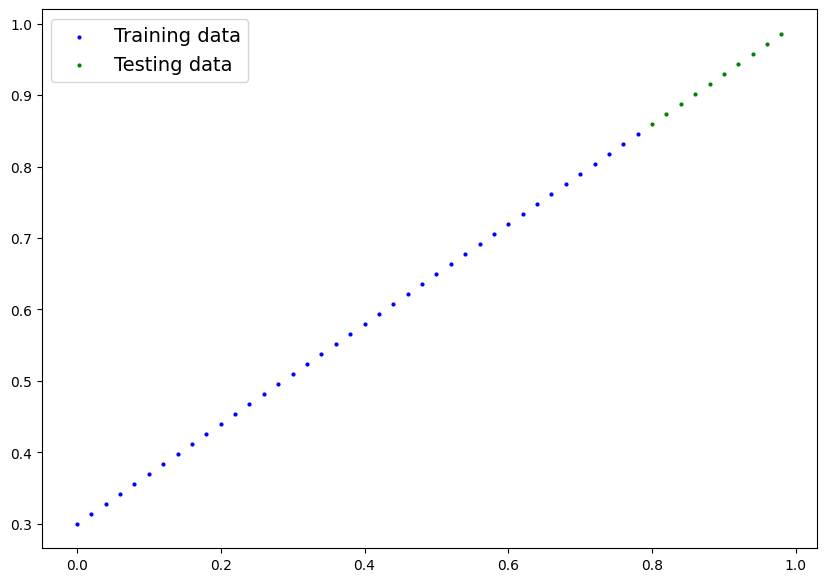

In [5]:
plot_predictions(X_train, y_train, X_test, y_test)

# 2. Build model

In [6]:
# create a linear regresison model class
from torch import nn
class LinearRegressionModel(nn.Module): #  almost everything in PyTorch is inheirted by Pytorch
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(1,
                               requires_grad = True,
                               dtype = torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad = True,
                                         dtype = torch.float))
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weight * x + self.bias

In [7]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([-0.6382], requires_grad=True)]

In [8]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.8823])), ('bias', tensor([-0.6382]))])

In [9]:
with torch.inference_mode():
  y_pred = model_0(X_test)

In [10]:
y_pred

tensor([[0.0677],
        [0.0853],
        [0.1030],
        [0.1206],
        [0.1382],
        [0.1559],
        [0.1735],
        [0.1912],
        [0.2088],
        [0.2265]])

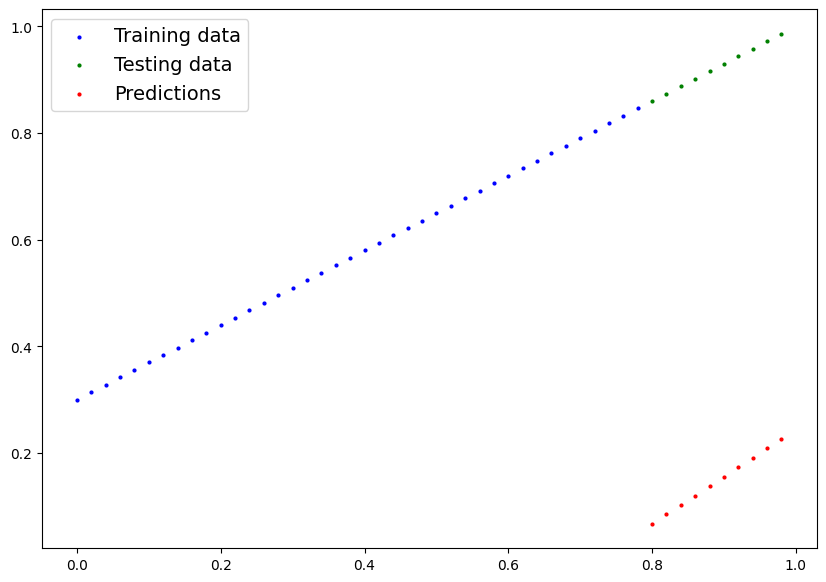

In [11]:
plot_predictions(predictions=y_pred)

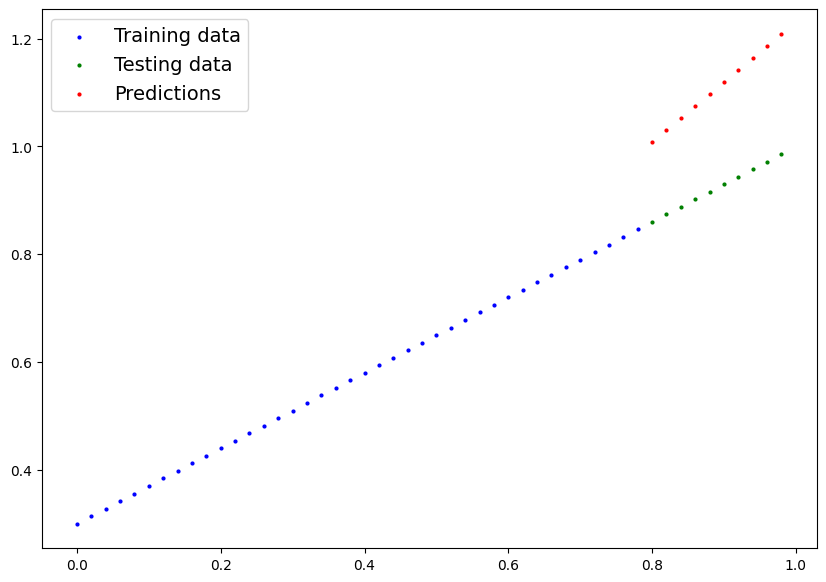

In [19]:
plot_predictions(predictions=test_pred)

# 3. Train model

In [12]:
loss_f = nn.L1Loss()

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.005) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))


In [13]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.005
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### Creating an optimization loop in PyTorch

In [14]:
# So the idea here is that when we calculate the loss after trainig the model at 1 epoch,
# it goes through calculating the loss and then reset the gradients which then backprop is applied
# once we have back prop we see how well the model does in that 1 epoch by seeing how well it does
# on the test dataset and then it gets calculated

torch.manual_seed(42)

epochs = 200

train_loss_a = []
test_loss_a = []
epoch_count = []

for epoch in range(epochs):
  model_0.train()
  y_pred = model_0(X_train)
  loss = loss_f(y_pred, y_train)
  optimizer.zero_grad() #
  loss.backward()
  optimizer.step() # makes some calculation based on the backprop of the loss and it will accumulate through the loop so we need to zero them above

  # Testing
  model_0.eval() # removes concepts of the dropout layers and the batch norm layers which are not needed for eval

  with torch.inference_mode(): # this turns off gradient tracking and a couple more things which are not needed for test
    test_pred = model_0(X_test)
    test_loss = loss_f(test_pred, y_test.type(torch.float))

    if epoch % 20 == 0:
      print(model_0.state_dict())
      epoch_count.append(epoch)
      train_loss_a.append(loss.detach().numpy())
      test_loss_a.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

OrderedDict([('weight', tensor([0.8842])), ('bias', tensor([-0.6332]))])
Epoch: 0 | MAE Train Loss: 0.8670692443847656 | MAE Test Loss: 0.7691990733146667 
OrderedDict([('weight', tensor([0.9232])), ('bias', tensor([-0.5332]))])
Epoch: 20 | MAE Train Loss: 0.7518590688705444 | MAE Test Loss: 0.6344887018203735 
OrderedDict([('weight', tensor([0.9622])), ('bias', tensor([-0.4332]))])
Epoch: 40 | MAE Train Loss: 0.6366490125656128 | MAE Test Loss: 0.4997783303260803 
OrderedDict([('weight', tensor([1.0012])), ('bias', tensor([-0.3332]))])
Epoch: 60 | MAE Train Loss: 0.5214388966560364 | MAE Test Loss: 0.3650679588317871 
OrderedDict([('weight', tensor([1.0402])), ('bias', tensor([-0.2332]))])
Epoch: 80 | MAE Train Loss: 0.40622878074645996 | MAE Test Loss: 0.2303576022386551 
OrderedDict([('weight', tensor([1.0792])), ('bias', tensor([-0.1332]))])
Epoch: 100 | MAE Train Loss: 0.29101866483688354 | MAE Test Loss: 0.09564723819494247 
OrderedDict([('weight', tensor([1.1182])), ('bias', ten

In [15]:
weight, bias

(0.7, 0.3)

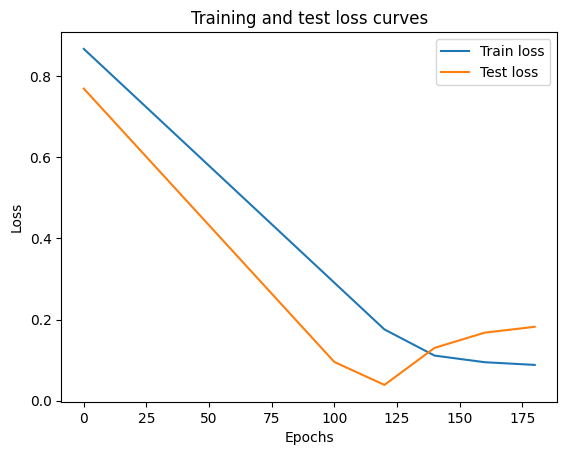

In [16]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_a, label="Train loss")
plt.plot(epoch_count, test_loss_a, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [17]:
model_0.state_dict()

OrderedDict([('weight', tensor([1.1139])), ('bias', tensor([0.1173]))])

# 5. Saving and loading a PyTorch model

In [20]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth" # pytoch object are either .pt or .pth file extension
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [21]:
model_0.state_dict()

OrderedDict([('weight', tensor([1.1139])), ('bias', tensor([0.1173]))])

In [22]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [23]:
loaded_model_0.eval()

with torch.inference_mode():
  load_model_preds = loaded_model_0(X_test)

In [26]:
y_preds == load_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6. Putting it all together

In [4]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

In [5]:
# gpu
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [6]:
# data

w = 0.7
b = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = w * X + b
print(X.shape)
X[:10], y[:10]

torch.Size([50, 1])


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [7]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [62]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features = 1,
                                  out_features = 1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, list(model_1.parameters())

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 [Parameter containing:
  tensor([[0.7645]], requires_grad=True),
  Parameter containing:
  tensor([0.8300], requires_grad=True)])

In [63]:
next(model_1.parameters()).device

device(type='cpu')

In [64]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [65]:
loss_f = nn.L1Loss()

# Create the optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # parameters of target model to optimize
                            lr=0.005) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))


In [85]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features = 1,
                                  out_features = 1)
  def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, list(model_1.parameters())

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 [Parameter containing:
  tensor([[0.7645]], requires_grad=True),
  Parameter containing:
  tensor([0.8300], requires_grad=True)])

In [86]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

In [87]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

In [88]:
epoch = 500

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

train_loss_b = []
test_loss_b = []

epoch_count_b = []

for i in range(epoch):
  model_1.train()
  y_pred = model_1(X_train)
  loss = loss_f(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_f(y_test, test_pred)

    if i % 100 == 0:
        print(f"Epoch: {i} | Train loss: {loss} | Test loss: {test_loss}")

    # if i % 20 == 0:
    #   print(model_1.state_dict())
    #   epoch_count_b.append(i)
    #   train_loss_b.append(loss.detach().cpu().numpy())
    #   test_loss_b.append(test_loss.detach().cpu().numpy())
    #   print(f"Epoch: {i} | MAE Train Loss: {train_loss_b} | MAE Test Loss: {test_loss_b}")


Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882


In [89]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

In [94]:
y_preds.cpu().numpy()

array([[0.8599563 ],
       [0.87389255],
       [0.88782877],
       [0.9017649 ],
       [0.9157011 ],
       [0.9296373 ],
       [0.9435735 ],
       [0.95750964],
       [0.9714458 ],
       [0.985382  ]], dtype=float32)

In [99]:
def plot_predictions(train_data=X_train.cpu().numpy(),
                     train_labels=y_train.cpu().numpy(),
                     test_data=X_test.cpu().numpy(),
                     test_labels=y_test.cpu().numpy(),
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

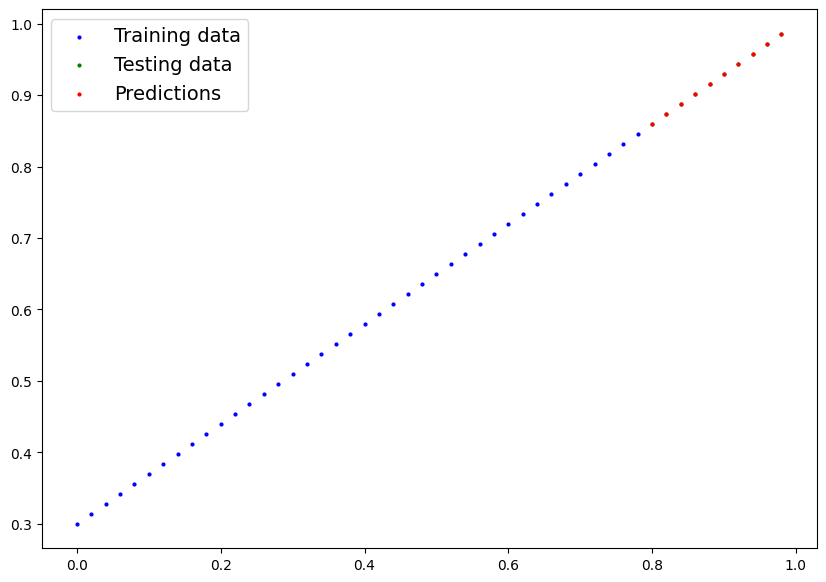

In [97]:
plot_predictions(predictions=y_preds.cpu().numpy())

In [95]:
X_train

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800],
        [0.2000],
        [0.2200],
        [0.2400],
        [0.2600],
        [0.2800],
        [0.3000],
        [0.3200],
        [0.3400],
        [0.3600],
        [0.3800],
        [0.4000],
        [0.4200],
        [0.4400],
        [0.4600],
        [0.4800],
        [0.5000],
        [0.5200],
        [0.5400],
        [0.5600],
        [0.5800],
        [0.6000],
        [0.6200],
        [0.6400],
        [0.6600],
        [0.6800],
        [0.7000],
        [0.7200],
        [0.7400],
        [0.7600],
        [0.7800]], device='cuda:0')

In [100]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth
